In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import scipy
from scipy import signal
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

out_dir='output_images/stage3/'

# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]    

In [2]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary,channels

def warp(img,tobird=True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

def warp_pipeline(img,vertices):
    undist = undistort(img)    
    result,_ = warp(undist)
    result = region_of_interest(result, vertices)
    return result
    
def warp_binarize_pipeline(img,vertices):
    undist = undistort(img)
    binary,_  = binarize(undist)
    result,_  = warp(binary)
    result = region_of_interest(result, vertices)
    return result 

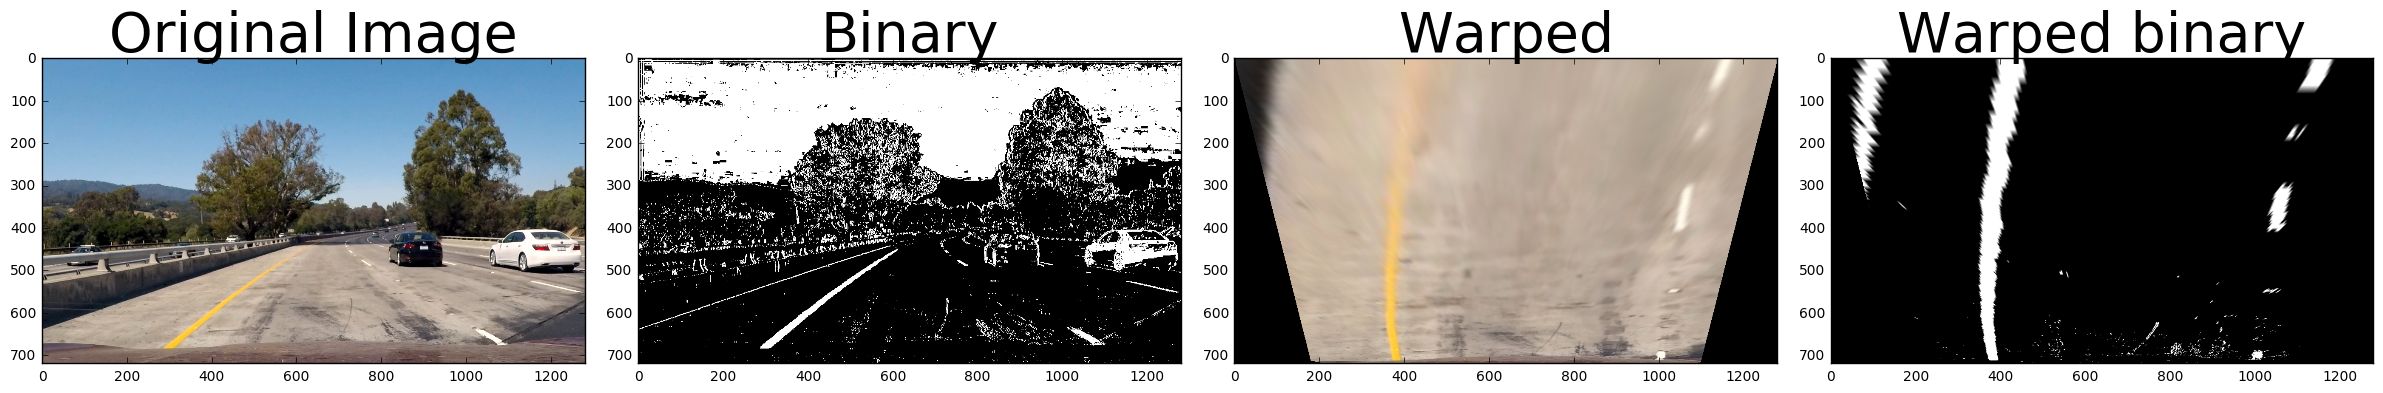

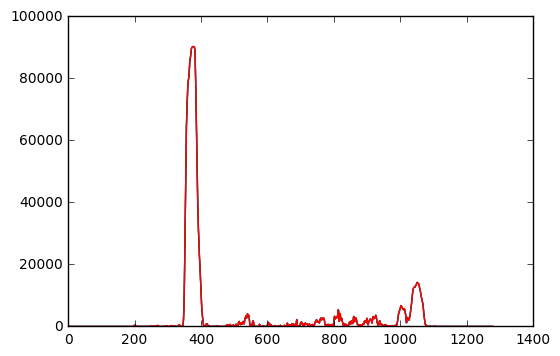

In [3]:
img = plt.imread('test_images/test1.jpg')
#img = plt.imread('output_images/stage2/straight_road.jpg')

shape = img.shape
vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

binary,_ = binarize(img)
warped = warp_pipeline(img,vertices)    
warped_binary = warp_binarize_pipeline(img,vertices)

# Plot the result
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary)
ax2.set_title('Binary', fontsize=40)

ax3.imshow(warped)
ax3.set_title('Warped', fontsize=40)

ax4.imshow(warped_binary)
ax4.set_title('Warped binary', fontsize=40)

plt.figure()
histogram = np.sum(warped_binary[warped_binary.shape[0]/2:,:], axis=0)
plt.plot(histogram)

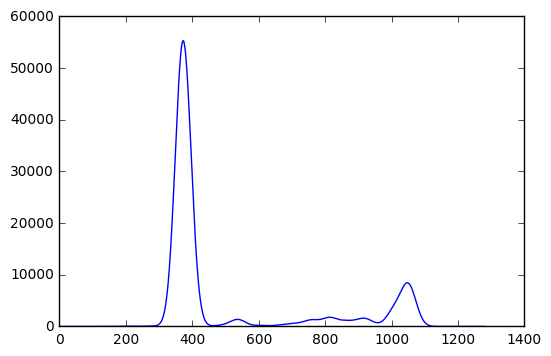

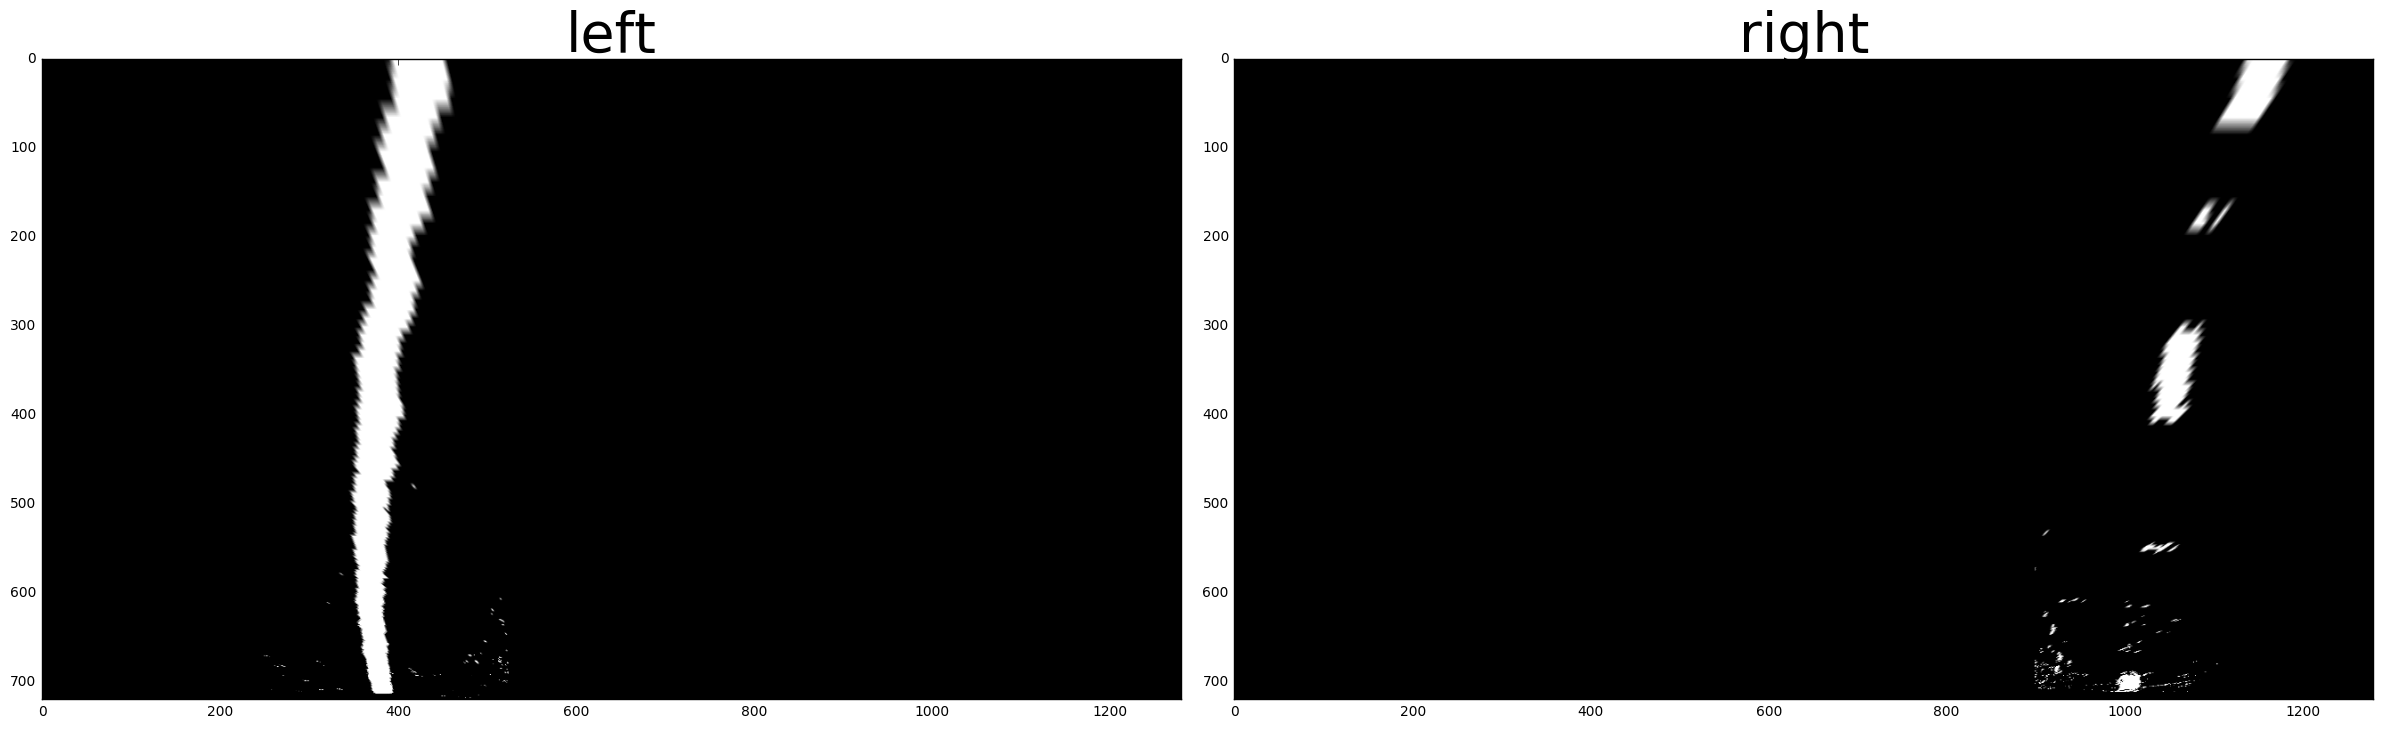

In [4]:

def find_peaks(img,thresh):
    img_half=img[img.shape[0]/2:,:,0]
    data = np.sum(img_half, axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(data,20)
    xs = np.arange(len(filtered))
    peak_ind = signal.find_peaks_cwt(filtered, np.arange(20,300))
    peaks = np.array(peak_ind)
    peaks = peaks[filtered[peak_ind]>thresh]
    return peaks,filtered


def get_next_window(img,x,width):
    """
    input: img,x,width
        img: binary 3 channel image
        x: center of window
        width: width of window
    
    output: masked,center_point
        masked : a masked image of the same size. mask is a window centered at x
        center : the mean ofall pixels found within the window
    """
    
    ny,nx,_ = img.shape
    mask  = np.zeros_like(img)
    if (x <= width/2): x = width/2
    if (x >= nx-width/2): x = nx-width/2
    
    left  = x - width/2
    right = x + width/2
    
    vertices = np.array([[(left,0),(left,ny), (right,ny),(right,0)]], dtype=np.int32)
    ignore_mask_color=(255,255,255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = x
        
    return masked,center

def lane_from_window(binary,x,width):
    n_zones=6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_window(zones[0],x,width)
    
    for zone in zones[1:]:
        next_window,center = get_next_window(zone,center,width)
        window = np.vstack((next_window,window))
    
    return window

peaks,filtered = find_peaks(warped_binary,thresh=3000)

plt.figure()
plt.plot(filtered)

width=300
left_lane=lane_from_window(warped_binary,peaks[0],width)
right_lane=lane_from_window(warped_binary,peaks[1],width)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(left_lane)
ax1.set_title('left', fontsize=40)

ax2.imshow(right_lane)
ax2.set_title('right', fontsize=40)

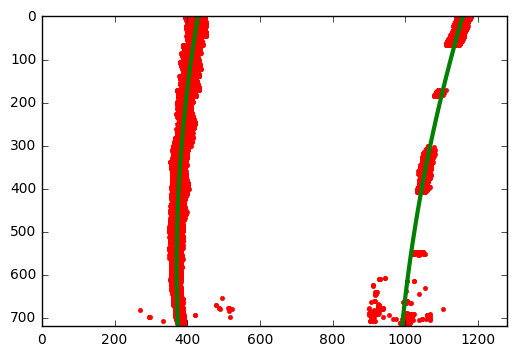

In [32]:
yvals_l,leftx=(left_lane[:,:,0]>254).nonzero()
yvals_r,rightx=(right_lane[:,:,0]>254).nonzero()

left_fit = np.polyfit(yvals_l, leftx, 2)
right_fit = np.polyfit(yvals_r, rightx, 2)

right_fitx = right_fit[0]*yvals_r**2 + right_fit[1]*yvals_r + right_fit[2]
left_fitx = left_fit[0]*yvals_l**2 + left_fit[1]*yvals_l + left_fit[2]


def get_lane_coords(lane):
    y,x=(lane[:,:,0]>254).nonzero()
    return y,x

yvals_l,leftx = get_lane_coords(left_lane)
yvals_r,rightx = get_lane_coords(right_lane)

# get fit coefficients
left_fit = np.polyfit(yvals_l, leftx, 2)
right_fit = np.polyfit(yvals_r, rightx, 2)

if len(yvals_l)> len(yvals_r):
    yvals=yvals_l
else:
    yvals=yvals_r
    
yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]


plt.plot(rightx, yvals_r, '.', color='red')
plt.plot(right_fitx, yvals, color='green', linewidth=3)

plt.plot(leftx, yvals_l, '.', color='red')
plt.plot(left_fitx, yvals, color='green', linewidth=3)

plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()

In [33]:
len(left_fitx)

101

In [34]:
def get_curvatures(y_eval):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
    return left_curverad,right_curverad

R_l,R_r= get_curvatures(max(yvals))
R_l,R_r

(2859.5030450901791, 3264.2816733944278)

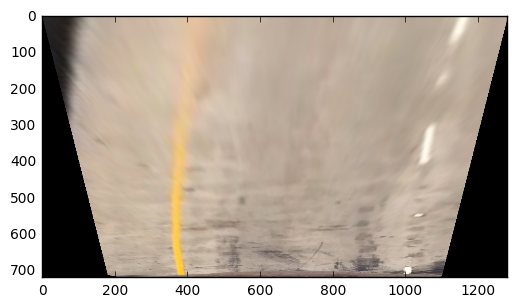

In [35]:
left_fitx
right_fitx
yvals
plt.imshow(warped)

(101, 101, 101)

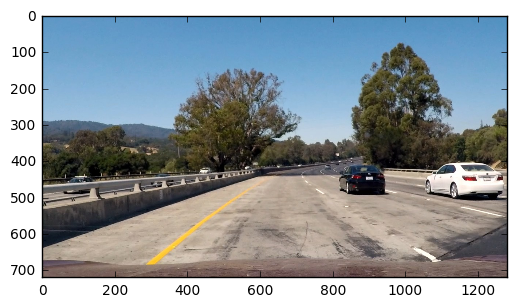

In [36]:
plt.imshow(img)
len(left_fitx),len(right_fitx),len(yvals)

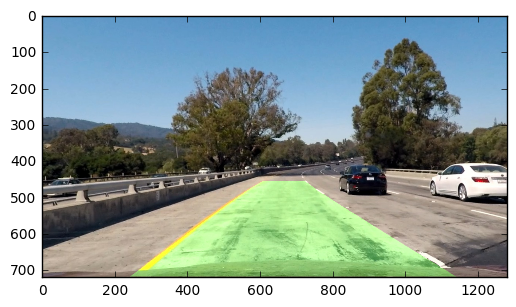

In [37]:
def project_lane_lines(img,left_fitx,right_fitx,yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    undist = undistort(img)    
    unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

result = project_lane_lines(img,left_fitx,right_fitx,yvals)
plt.imshow(result)

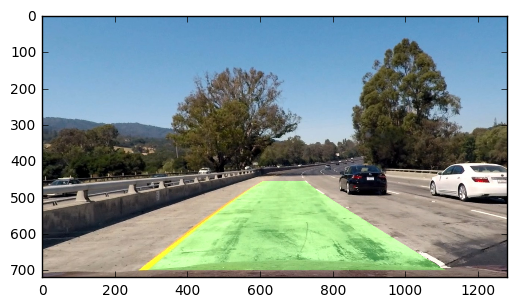

In [38]:
def process_image(img):
    undist = undistort(img)
    binary,_  = binarize(undist)
    warped,_  = warp(binary)
    warped_binary = region_of_interest(warped, vertices)
    
    peaks,filtered = find_peaks(warped_binary,thresh=3000)
    width=300
    left_lane=lane_from_window(warped_binary,peaks[0],width)
    right_lane=lane_from_window(warped_binary,peaks[1],width)
    yvals_l,leftx=get_lane_coords(left_lane)
    yvals_r,rightx=get_lane_coords(right_lane)

    # get fit coefficients
    left_fit = np.polyfit(yvals_l, leftx, 2)
    right_fit = np.polyfit(yvals_r, rightx, 2)

    
    if len(yvals_l)> len(yvals_r):
        yvals=yvals_l
    else:
        yvals=yvals_r
        
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]

    result = project_lane_lines(img,left_fitx,right_fitx,yvals)
    return result


result=process_image(img)
plt.imshow(result)    

In [123]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self,n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # start from scratch?
        self.restart = False 
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def set_current_fit_xvals(self):
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
    def add_data(self):
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
            
    def set_avgcoeffs(self):
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
    
    def set_allxy(self,lane_candidate):
        self.ally,self.allx = (lane_candidate[:,:,0]>254).nonzero()

    def set_current_fit_coeffs(self):
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
    
    def get_diffs(self):
        if self.n_buffered>0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')                 
            
    def set_radius_of_curvature(self):
        # Define y-value where we want radius of curvature (choose bottom of the image)
        y_eval = max(self.fit_yvals)
        self.radius_of_curvature = ((1 + (2*self.current_fit_coeffs[0]*y_eval + self.current_fit_coeffs[1])**2)**1.5) \
                             /np.absolute(2*self.current_fit_coeffs[0])
                        
            
    def set_line_base_pos(self):
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            maxdelta = 0.15 
            if not all(i <= 0.15 for i in abs(relative_delta)):
                print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self,lane):
        self.set_allxy(lane)
        self.set_current_fit_coeffs()
        self.set_current_fit_xvals()
        self.set_radius_of_curvature()
        self.set_line_base_pos()
        self.get_diffs()
        if self.accept_lane():
            self.detected=True
            self.add_data()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected=False            
            self.pop_data()
            if self.n_buffered>0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected,self.n_buffered
    

left = Line()        
detected,n_buffered = left.update(right_lane)
detected,n_buffered = left.update(right_lane)
detected,n_buffered = left.update(left_lane)
detected,n_buffered = left.update(left_lane)
detected,n_buffered


fit coeffs too far off [%] [ 0.12203645 -0.41014081 -0.62908037]
fit coeffs too far off [%] [ 0.12203645 -0.41014081 -0.62908037]


(False, 0)

In [125]:
img = warped_binary
peaks,filtered = find_peaks(img,thresh=3000)
if len(peaks)!=2:
    print('Error no two lanes detected')
width=300

line_positions=np.zeros(2)

left_binary = lane_from_window(img,peaks[0],width)
left=Line()
left.update(left_binary)
print('left_lane pos: ',left.line_pos)
line_positions[0] = left.line_pos

right_binary = lane_from_window(img,peaks[1],width)
right=Line()
right.update(right_binary)
print('right_lane pos: ',right.line_pos)
line_positions[1] = right.line_pos


line_spacing=right.line_base_pos-left.line_base_pos
print('line_spacing [m]:',line_spacing)
line_positions




## Plot the result
#f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#
#ax1.imshow(lane_lines[0])
#ax1.set_title('left', fontsize=40)
#
#ax2.imshow(lane_lines[1])
#ax2.set_title('right', fontsize=40)

left_lane pos:  374.443349218
right_lane pos:  991.451740043
line_spacing [m]: 3.80488507676


array([ 374.44334922,  991.45174004])

In [112]:
2.16+1.63

3.79

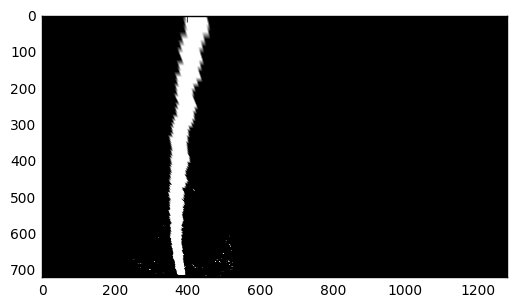

In [360]:
plt.imshow(left_lane)

In [148]:
out_dir='output_images/stage3/'
output = out_dir+'stage3_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage3/stage3_project_video.mp4
[MoviePy] Writing video output_images/stage3/stage3_project_video.mp4


 19%|█▉        | 240/1261 [00:53<03:44,  4.54it/s]

KeyboardInterrupt: 

In [1]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    
        
    
        


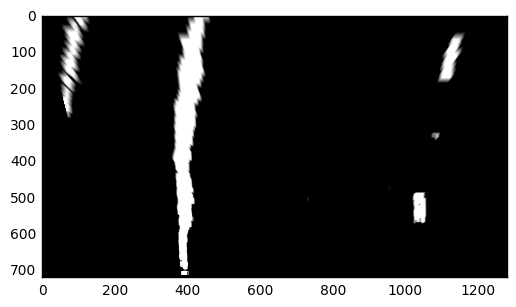

In [293]:
kernel = np.ones((10,5),np.uint8)
opening = cv2.morphologyEx(warped_binary, cv2.MORPH_OPEN, kernel)

plt.imshow(opening)


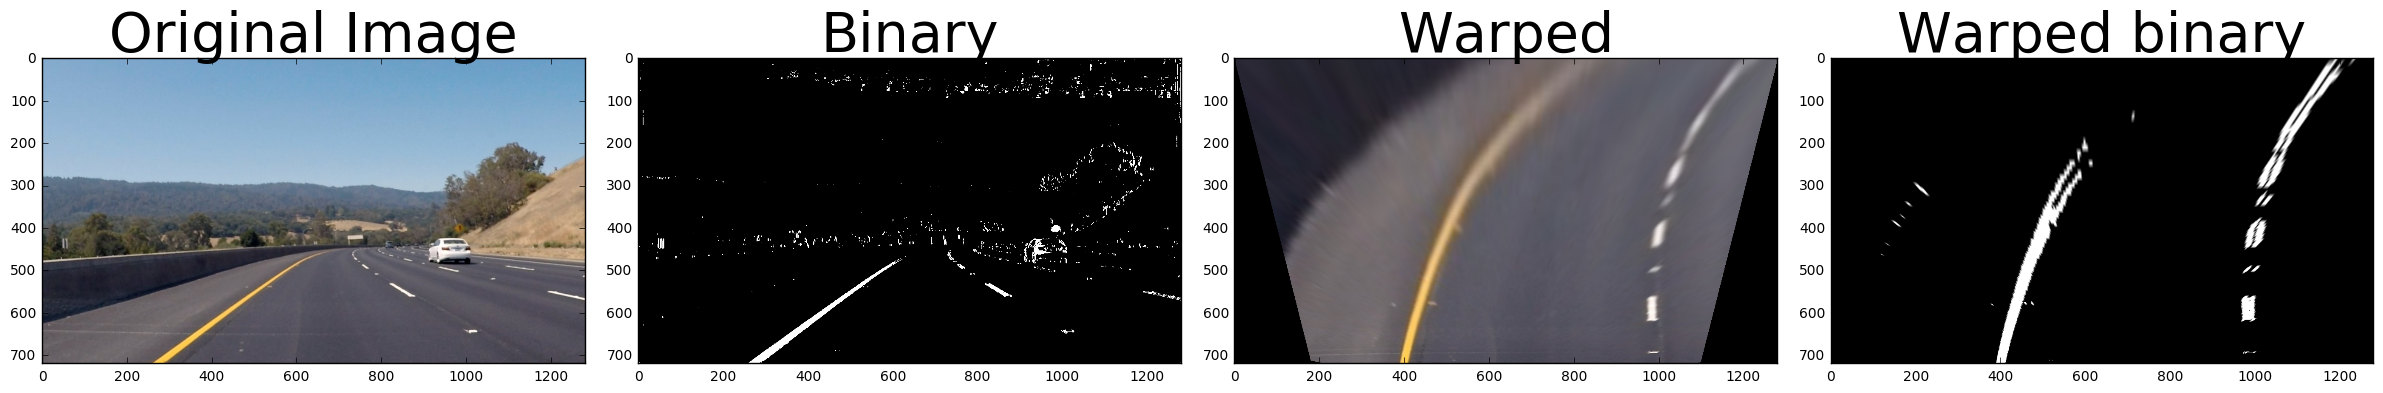

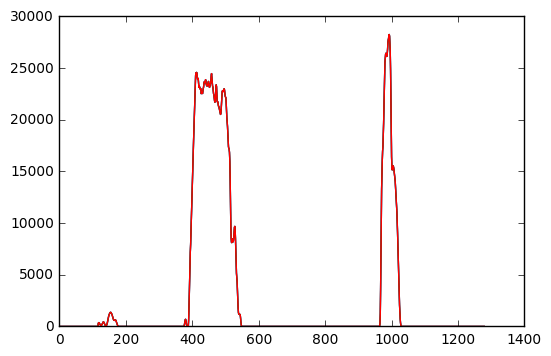

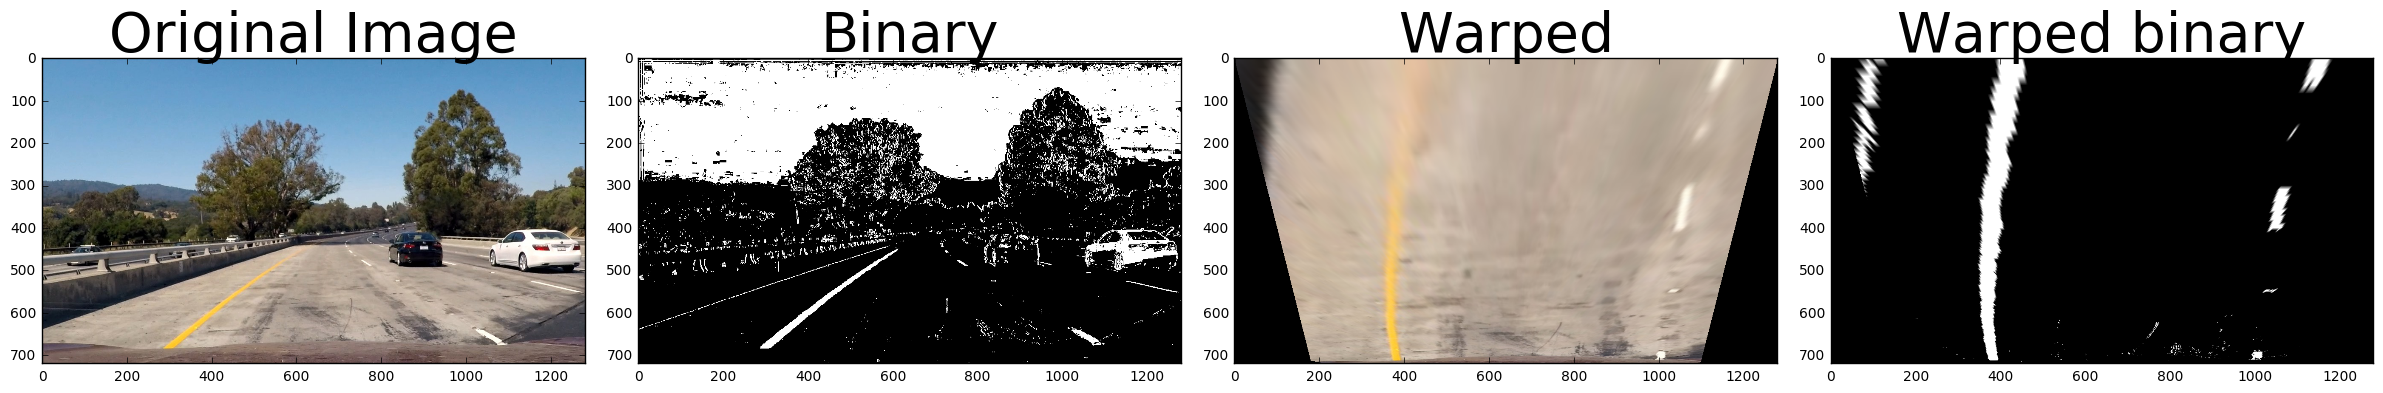

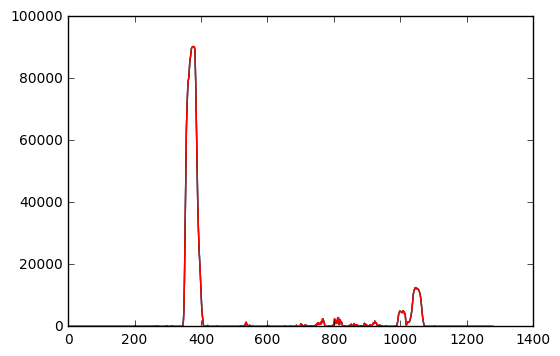

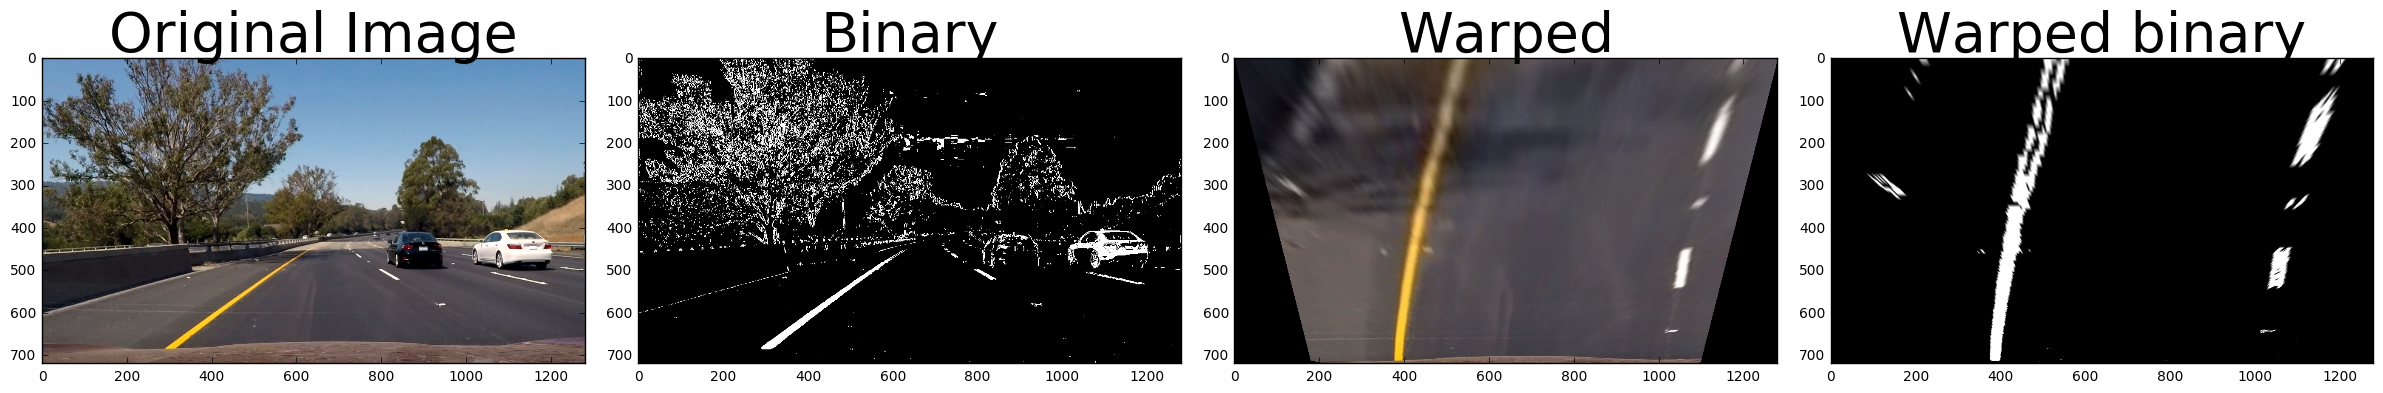

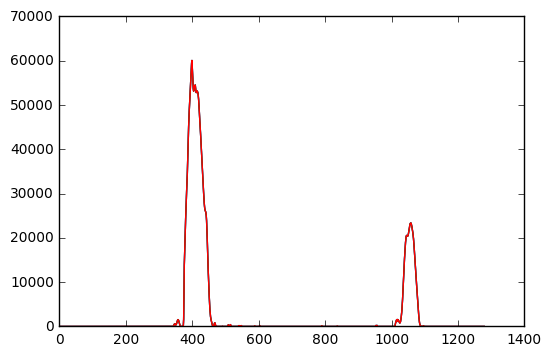

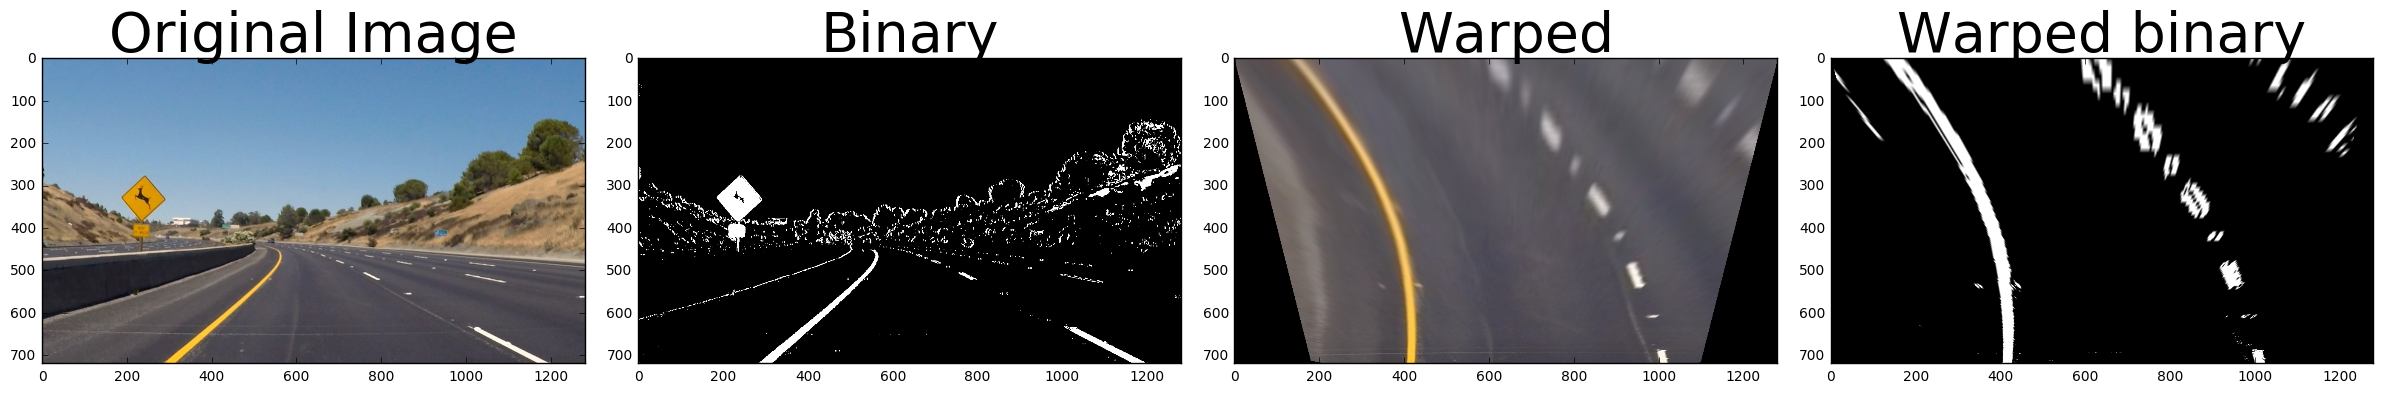

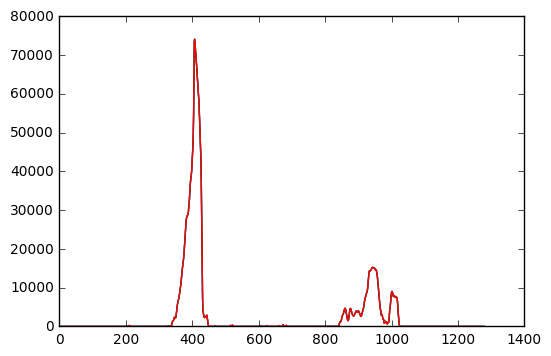

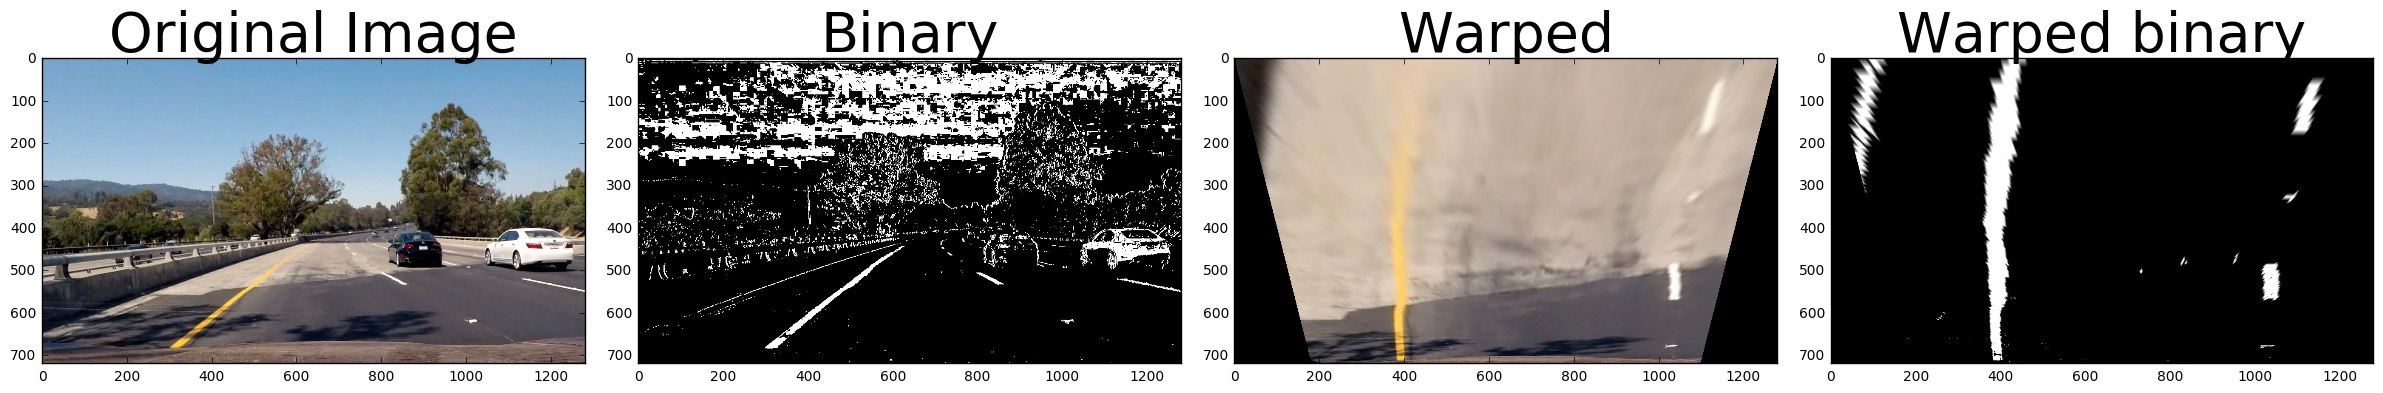

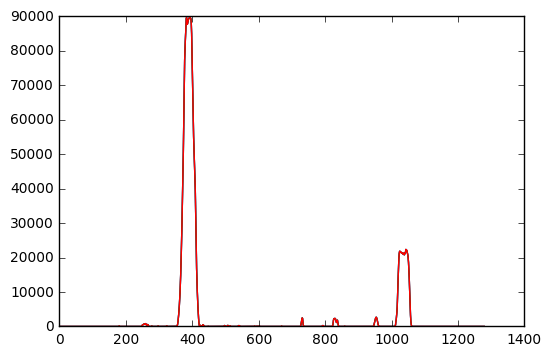

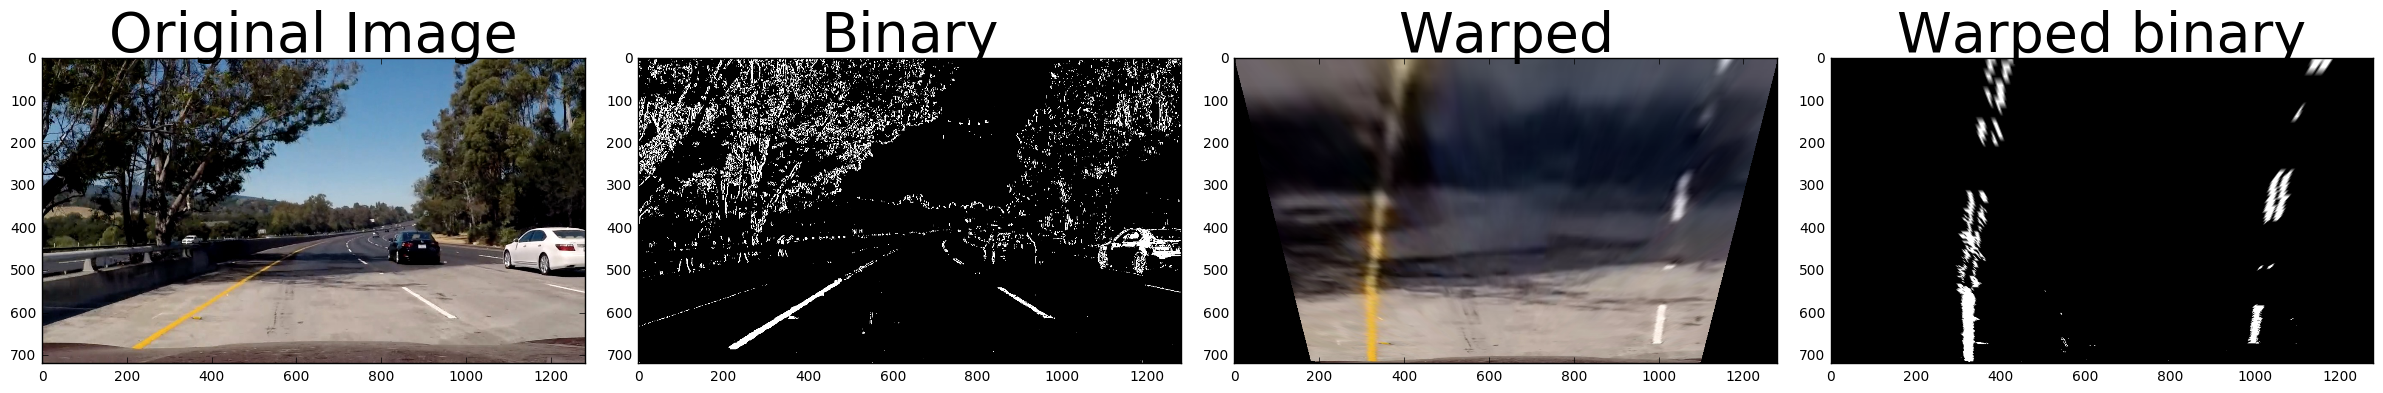

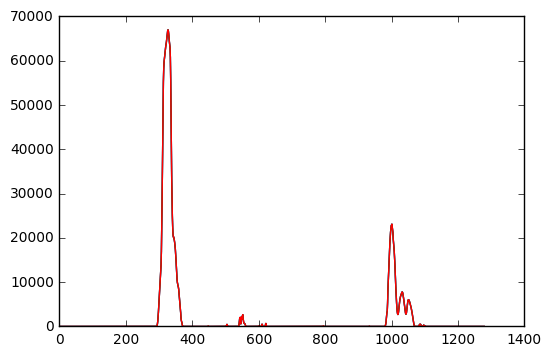

In [4]:
# Step through the test images and create the binary masks
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(images):
    img = plt.imread(fname)
    binary,_ = binarize(img)
    warped = warp_pipeline(img,vertices)    
    warped_binary = warp_binarize_pipeline(img,vertices)
    plt.figure()
    # Plot the result
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(binary)
    ax2.set_title('Binary', fontsize=40)

    ax3.imshow(warped)
    ax3.set_title('Warped', fontsize=40)

    ax4.imshow(warped_binary)
    ax4.set_title('Warped binary', fontsize=40)

    plt.figure()
    histogram = np.sum(warped_binary[warped_binary.shape[0]/2:,:], axis=0)
    plt.plot(histogram)
    from scipy import signal
    data = histogram[:,0]
    xs = np.arange(len(data))
    peakind = signal.find_peaks_cwt(data, np.arange(100,200))
    peakind, xs[peakind], data[peakind]
    
    


In [122]:
def process_image(image):
    birds_eye_mask = warp_mask(image)
    return birds_eye_mask

output = out_dir+'stage2_birds_eye_mask_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage2/stage2_birds_eye_mask_project_video.mp4
[MoviePy] Writing video output_images/stage2/stage2_birds_eye_mask_project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 2/1261 [00:00<01:42, 12.28it/s]

  0%|          | 4/1261 [00:00<01:37, 12.83it/s]

  0%|          | 6/1261 [00:00<01:35, 13.21it/s]

  1%|          | 8/1261 [00:00<01:32, 13.48it/s]

  1%|          | 10/1261 [00:00<01:33, 13.36it/s]

  1%|          | 12/1261 [00:00<01:33, 13.30it/s]

  1%|          | 14/1261 [00:01<01:32, 13.55it/s]

  1%|▏         | 16/1261 [00:01<01:33, 13.32it/s]

  1%|▏         | 18/1261 [00:01<01:32, 13.49it/s]

  2%|▏         | 20/1261 [00:01<01:30, 13.67it/s]

  2%|▏         | 22/1261 [00:01<01:34, 13.07it/s]

  2%|▏         | 24/1261 [00:01<01:33, 13.29it/s]

  2%|▏         | 26/1261 [00:01<01:34, 13.14it/s]

  2%|▏         | 28/1261 [00:02<01:34, 13.02it/s]

  2%|▏         | 30/1261 [00:02<01:34, 13.02it/s]

  3%|▎         | 32/1261 [00:02<01:33, 13.13it/s]

  3%|▎         | 34/1261 [00:02<01:31, 13.40it/s]

  3%|▎         | 36/1261 [00:02<01:32, 13.19it/s]

  3%|▎         | 38/1261 [00:02<01:30, 13.

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/stage2/stage2_birds_eye_mask_project_video.mp4 

CPU times: user 6min 20s, sys: 1.4 s, total: 6min 21s
Wall time: 1min 38s


In [123]:
def process_image(image):
    birds_eye = warp(image)
    return birds_eye

output = out_dir+'stage2_birds_eye_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage2/stage2_birds_eye_project_video.mp4
[MoviePy] Writing video output_images/stage2/stage2_birds_eye_project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 3/1261 [00:00<00:47, 26.36it/s]

  0%|          | 6/1261 [00:00<00:49, 25.21it/s]

  1%|          | 9/1261 [00:00<00:50, 24.84it/s]

  1%|          | 12/1261 [00:00<00:49, 25.33it/s]

  1%|          | 15/1261 [00:00<00:50, 24.91it/s]

  1%|▏         | 18/1261 [00:00<00:49, 25.35it/s]

  2%|▏         | 21/1261 [00:00<00:49, 24.81it/s]

  2%|▏         | 24/1261 [00:00<00:48, 25.33it/s]

  2%|▏         | 27/1261 [00:01<00:47, 26.03it/s]

  2%|▏         | 30/1261 [00:01<00:46, 26.38it/s]

  3%|▎         | 33/1261 [00:01<00:46, 26.65it/s]

  3%|▎         | 36/1261 [00:01<00:46, 26.49it/s]

  3%|▎         | 39/1261 [00:01<00:45, 26.64it/s]

  3%|▎         | 42/1261 [00:01<00:46, 25.95it/s]

  4%|▎         | 45/1261 [00:01<00:50, 23.98it/s]

  4%|▍         | 48/1261 [00:01<00:51, 23.43it/s]

  4%|▍         | 51/1261 [00:02<00:52, 23.12it/s]

  4%|▍         | 54/1261 [00:02<00:54, 22.23it/s]

  5%|▍         | 57/1261 [00:02<00:56, 21

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/stage2/stage2_birds_eye_project_video.mp4 

CPU times: user 4min 8s, sys: 864 ms, total: 4min 8s
Wall time: 1min 3s


In [14]:
output = out_dir+'stage1_binary_challenge_video.mp4'
clip = VideoFileClip("challenge_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage1/stage1_binary_challenge_video.mp4
[MoviePy] Writing video output_images/stage1/stage1_binary_challenge_video.mp4


100%|██████████| 485/485 [00:34<00:00, 14.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/stage1/stage1_binary_challenge_video.mp4 

CPU times: user 1min 43s, sys: 660 ms, total: 1min 43s
Wall time: 34.6 s


In [ ]:

    
#imgray = cv2.cvtColor(zones[i],cv2.COLOR_RGB2GRAY)
#imgray = cv2.erode(imgray, None, iterations=4)
#imgray = cv2.dilate(imgray, None, iterations=4)
#im2, contours, hierarchy = cv2.findContours(imgray,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#print(len(contours))#
#
#for cnt in contours:
#    x,y,w,h = cv2.boundingRect(cnt)
#    cv2.rectangle(zones[i],(x,y),(x+w,y+h),(0,255,0),2)
        
##cv2.drawContours(imgray, contours, -1, (0,255,0), 3)
#plt.imshow(zones[i])

#M = cv2.moments(cnt)
#
#
#distances=np.diff(p)
#print(distances)
#p,data[p]


In [308]:
3.7/600


0.006166666666666667